In [1]:

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
DATASET_DIR = "dataset/"  # This folder must contain "good street/" and "street with holes/"


In [3]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, dest_dir, test_size=0.2, val_size=0.2):
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        images = [img for img in images if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

        train_val_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
        train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=val_size/(1 - test_size), random_state=42)

        for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_class_dir = os.path.join(dest_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img_name in split_imgs:
                src_img = os.path.join(class_path, img_name)
                dst_img = os.path.join(split_class_dir, img_name)
                shutil.copy(src_img, dst_img)

# Example use:
split_dataset(DATASET_DIR, 'dataset_split', test_size=0.2, val_size=0.2)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For all sets: normalize
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'dataset_split/train',
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    'dataset_split/val',
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    'dataset_split/test',
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)


Found 10894 images belonging to 2 classes.
Found 3632 images belonging to 2 classes.
Found 3633 images belonging to 2 classes.


In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5), 
    
    Flatten(),
    Dropout(0.6),  # Very high dropout before dense
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [8]:
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
]

In [9]:
print("Class counts:")
print(np.bincount(train_generator.labels))
# Example output: [10500  9500] for ~20k images

Class counts:
[6318 4576]


In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


d:\Street-holes-recognition\tf-env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.6529 - loss: 0.6477 - val_accuracy: 0.8984 - val_loss: 0.4137
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8936 - loss: 0.3895 - val_accuracy: 0.9210 - val_loss: 0.3662
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9238 - loss: 0.3576 - val_accuracy: 0.9397 - val_loss: 0.3432
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9368 - loss: 0.3368 - val_accuracy: 0.9438 - val_loss: 0.3150
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9427 - loss: 0.3131 - val_accuracy: 0.9367 - val_loss: 0.3156
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9503 - loss: 0.2896 - val_accuracy: 0.9576 - val_loss: 0.2721
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9559 - loss: 0.2672 - val_accuracy: 0.9595 - val_loss: 0.2568
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9562 - loss: 0.2570 - val_accuracy: 0.9623 - val_los

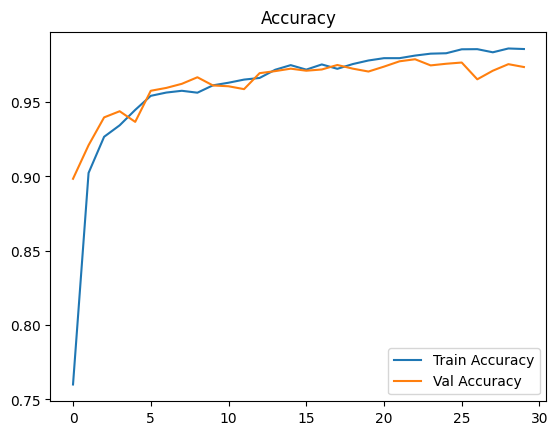

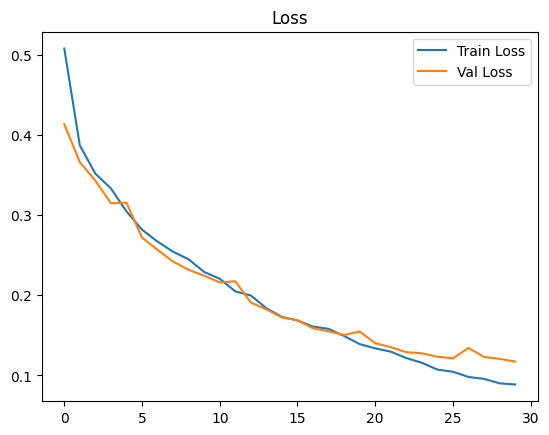

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [12]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.9786 - loss: 0.0617
Validation Accuracy: 0.97


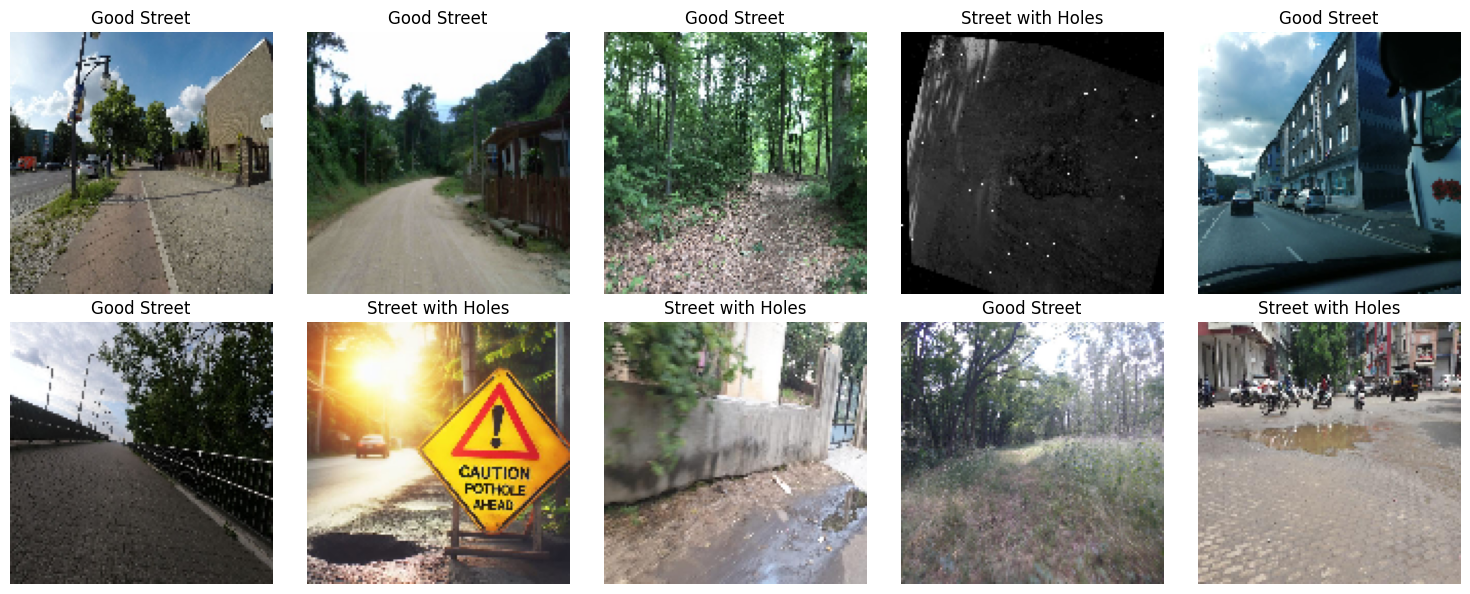

In [16]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)

plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = (images[i] * 255).astype(np.uint8)  # Convert back to 0–255 for visualization
    plt.imshow(img)
    label = 'Good Street' if labels[i] == 0 else 'Street with Holes'
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


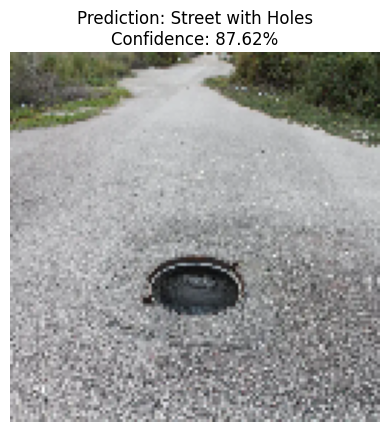

In [21]:
import matplotlib.pyplot as plt

# Test-time augmentation: horizontal flip, vertical flip, original
augmented_imgs = [
    img,
    img.transpose(method=0),  # horizontal flip
    img.transpose(method=1),  # vertical flip
]

preds = []
for aug_img in augmented_imgs:
    aug_array = image.img_to_array(aug_img) / 255.0
    aug_array = np.expand_dims(aug_array, axis=0)
    pred = model.predict(aug_array)[0][0]
    preds.append(pred)

mean_pred = np.mean(preds)
label = "Street with Holes" if mean_pred > 0.5 else "Good Street"
confidence = mean_pred if mean_pred > 0.5 else 1 - mean_pred

plt.imshow(img)
plt.title(f"Prediction: {label}\nConfidence: {confidence:.2%}")
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# 1. Save the trained model
model.save('street_classifier.h5')  # Best format for reloading 
print("Model saved and verified for instant predictions!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Test prediction: 0.6993
Model saved and verified for instant predictions!
